<a href="https://colab.research.google.com/github/fanton01/streamlit-example/blob/master/House_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ΠΡΟΒΛΕΨΗ ΤΙΜΗΣ ΣΠΙΤΙΟΥ





In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sklearn_pandas
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import csv
import sys
import scipy
import warnings
warnings.filterwarnings('ignore')

### Διαβάζει το  CSV file ως Dataframe:

In [ ]:
#train data
data_df = pd.read_csv("train.csv")
#test data
test_df = pd.read_csv("test.csv")
all_data = pd.concat((data_df.loc[:,:], test_df.loc[:, :]))

### Exploratory Data Analysis and Data tidying

I noticed that the dataset consists of 38 numerical columns of 81 all.
Morover, some columns contain missing data, i.e."LotFrontage", "MasVnrArea".

**The prediction target is 'SalePrice'. Let's look closer to this column.**

<Axes: xlabel='SalePrice', ylabel='Density'>

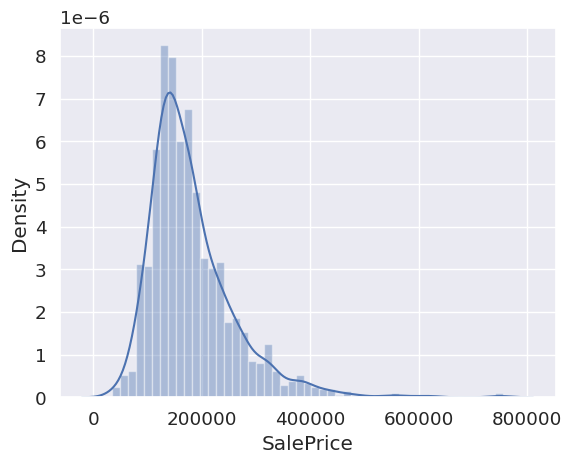

In [ ]:
# The Density Plot of SalePrice
sns.distplot(data_df['SalePrice'])

Κανονικοποιω το sales price με την χρηση του Logarithm transformation.

Text(0.5, 1.0, 'Density plot of SalePrice after Log Transformation')

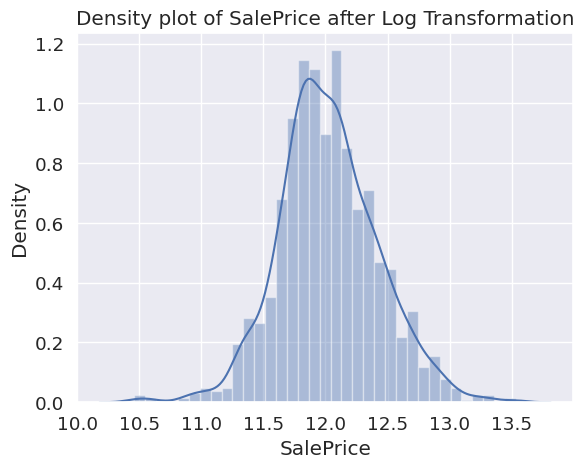

In [ ]:
data_df["SalePrice"] = np.log1p(data_df["SalePrice"])
# SalePrice after Log-transformation
sns.distplot(data_df["SalePrice"])
plt.title("Density plot of SalePrice after Log Transformation")

In [ ]:
y_train = data_df["SalePrice"]

#### Στήλες με Nan values

Αρχικα βλεπω ποσα Nan values εχω σε καθε στηλη.

Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

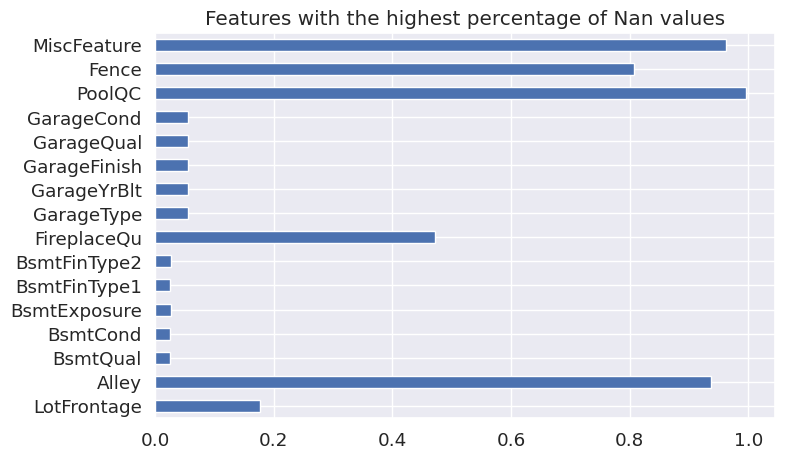

In [ ]:
col_nan = data_df.isna().sum() / data_df.shape[0]
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

**Αφαίρεση στηλών**
Αφαιρω την στηλη ID καθώς και τις στήλες Pave και AllPub αφου εχουν μονο μια μεταβλητη

In [ ]:
# Dropping columns for both train and test dataset
data_df = data_df.drop("Id", axis=1)
test_df = test_df.drop("Id", axis=1)
data_df = data_df.drop(["Street", "Utilities"], axis=1)
test_df = test_df.drop(["Street", "Utilities"], axis=1)

In [ ]:
# Concatenate all data together - both train and test

all_data = pd.concat([data_df, test_df]).reset_index(drop=True)

**LotFrontage feature**

LotFrontage is  a linear feet of street connected to property. I think it is a high probability that these values are similar to houses in the same Neighborhood. I check some statistics for them.

In [ ]:
neigh_lot_frontage = all_data.groupby('Neighborhood')['LotFrontage'].agg(["mean", "median"])
neigh_lot_frontage['avg_mean_median'] = (neigh_lot_frontage['mean'] + neigh_lot_frontage['median'] )/ 2
neigh_lot_frontage

,mean,median,avg_mean_median
Neighborhood,,,
Blmngtn,46.900000,43.0,44.950000
Blueste,27.300000,24.0,25.650000
BrDale,21.500000,21.0,21.250000
BrkSide,55.789474,51.0,53.394737
ClearCr,88.150000,80.5,84.325000
CollgCr,71.336364,70.0,70.668182
Crawfor,69.951807,70.0,69.975904
Edwards,66.910112,65.0,65.955056
Gilbert,74.207207,64.0,69.103604


In [ ]:
# transformation into medians
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

**Transformation of some numerical variables that are actually categorical.**

In [ ]:
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df

In [ ]:
num_to_categ_features = ['MSSubClass', 'OverallCond']#, 'YrSold', 'MoSold']

all_data = convert_to_string(all_data, columns = num_to_categ_features)

**Replacing missing values in the rest of numerical columns**

For the other numerical data I will also estimate them according to their statistics and for that I will use SimpleImputer object from sklearn library. For columns: BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, BsmtFullBath and BsmtHalfBath , MasVnrArea I will fill Nan values with constant = 0 and for the rest with median.

In [ ]:
num_features = all_data.select_dtypes(include=['int64','float64']).columns
num_features_to_constant = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"]
num_features_to_median = [feature for feature in num_features if feature not in num_features_to_constant + ["SalePrice"]]

In [ ]:
# Generating numerical features as input to DataFrameMapper.
numeric_features_median = sklearn_pandas.gen_features(columns=[num_features_to_median],
                                               classes=[{'class': SimpleImputer,
                                                         'strategy': 'median',
                                                         'missing_values' : np.nan}])

numeric_features_zero = sklearn_pandas.gen_features(columns=[num_features_to_constant],
                                               classes=[{'class': SimpleImputer,
                                                         'strategy': 'constant',
                                                         'fill_value' : 0,
                                                         'missing_values' : np.nan}])

missing_val_imputer = sklearn_pandas.DataFrameMapper(numeric_features_median + numeric_features_zero)

# Fitting
imputed_median = missing_val_imputer.fit(all_data)

# Transformation
imputed_features = imputed_median.transform(all_data)

# Putting into dataframe
imputed_df = pd.DataFrame(imputed_features, index=all_data.index, columns=num_features_to_median + num_features_to_constant)


**Categorical to numeral**

There is a lot of categorical features in data, so the next step is to transform  them into numerical values.

In [ ]:
# Selecting category features
cat_feats = all_data.select_dtypes(include=['object']).columns

According to data description (possible values for each feature) on Kaggle, I created a list of conversion values, specific for each column.

In [ ]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"),
                  ("Electrical", "SBrkr"),
                  ("BsmtCond","TA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"),
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"),
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"),
                  ("GarageFinish","No"),
                  ("GarageQual","NA"),
                  ("GarageCond","NA"),
                  ("HeatingQC","TA"),
                  ("KitchenQual","TA"),
                  ("Functional","Typ"),
                  ("GarageType","No"),
                  ("GarageFinish","No"),
                  ("GarageQual","No"),
                  ("GarageCond","No"),
                  ("HeatingQC","TA"),
                  ("KitchenQual","TA"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "VinylSd"),
                  ("Exterior2nd", "VinylSd"),
                  ("SaleType", "WD")]

I implemented the none_transform function which converts missing categorical values into specific strings from the none_conversion dictionary.

In [ ]:
def none_transform(df, conversion_list):
    ''' Function that converts missing categorical values
    into specific strings according to "conversion_list"

    Returns the dataframe after transformation.
    '''
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df

In [ ]:
# Applying the "none_transform" function
all_data = none_transform(all_data, none_conversion)

In [ ]:
len(all_data.columns)

78

**Transformation of skewed features**

As for linear models preferable are normally distributed data, I am transforming the skewed features to make them more normally distributed.

In [ ]:
# collecting the numeric features without considering SalePrice
numeric_features = [feat for feat in num_features if feat not in ['SalePrice']]

# selecting columns with skew more than 0.5
skewed_features = all_data[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.5].index
print("\nHighly skewed features: \n\n{}".format(skewed_features.tolist()))


Highly skewed features: 

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']



A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape.

In [ ]:
#The “optimal lambda” is the one that results in the best approximation of a normal distribution curve. I selected lambda= 0.15.

lambda_ = 0.15
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature], lambda_)

**Categorical into Numerical**


As some categorical features (i.e. **KitchenQual**, **GarageQual**) can be transformed into the numerical values with some order, I also implemented a new encoder for them.

In [ ]:
class OrderedLabelTransformer(BaseEstimator, TransformerMixin):
    orderDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}

    @staticmethod
    def get_dict(X):
        FirstDict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        SecondDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
        ThirdDict = {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        for d in [FirstDict, SecondDict, ThirdDict]:
            if set(X) == set(d):
                return d

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def get_label(t):
            return self.orderDict[t]
        return np.array([get_label(n) for n in X])

Some Neighborhood seems to be more expensive than the others so..:

In [ ]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2,
                        'MeadowV' : 0, 'IDOTRR' : 0, 'BrDale' : 0 ,
                        'CollgCr': 1, 'Veenker' : 1, 'Crawfor' : 1,
                        'Mitchel' : 1, 'Somerst' : 1, 'NWAmes' : 1,
                        'OldTown' : 1, 'BrkSide' : 1, 'Sawyer' : 1,
                        'NAmes' : 1, 'SawyerW' : 1, 'Edwards' : 1,
                        'Timber' : 1, 'Gilbert' : 1, 'ClearCr' : 1,
                        'NPkVill' : 1, 'Blmngtn' : 1, 'SWISU' : 1,
                        'Blueste': 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def get_label(t):
            return self.neighborhoodsmap[t]
        return np.array([get_label(n) for [n] in X])


As I implemented previously specific transformers for categorical data, I will run the whole pipeline for them.

In [ ]:
# Generating features:
order_feats = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual",
               "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]

original_features_df = all_data[order_feats + ['Neighborhood']] # we need to save original values for one-hot encoding

order_features = sklearn_pandas.gen_features(order_feats, [OrderedLabelTransformer])
neighb_features = [(['Neighborhood'], [NeighborhoodTransformer()])]

# Pipeline
label_encoder = sklearn_pandas.DataFrameMapper(neighb_features + order_features)

# The list with order of column names
cols = ["Neighborhood"] + order_feats

# Transformation both train and test set
transformed_feats = label_encoder.fit_transform(all_data)

# Putting transformed features into dataframe
transformed_df = pd.DataFrame(transformed_feats, index=all_data.index, columns=cols)

In [ ]:
original_features_df.shape

(2919, 10)

In [ ]:
# feature without any transformation till now
rest_features = set(pd.concat([imputed_df, original_features_df],axis=1).columns).symmetric_difference(set(all_data.columns))
rest_features_df = all_data[list(rest_features)]

In [ ]:
all_data = pd.concat([imputed_df, original_features_df, rest_features_df],axis=1)

In [ ]:
all_data.shape

(2919, 77)

**One-hot encoding**

In [ ]:
all_data = all_data.drop(["SalePrice"], axis = 1)

hot_one_features = pd.get_dummies(all_data).reset_index(drop=True)
hot_one_features.shape

(2919, 316)

In [ ]:
all_data = pd.concat([transformed_df, hot_one_features],axis=1)

## Splitting into train/test

In [ ]:
train_preprocessed = all_data.iloc[:len(data_df),:]
test_preprocessed = all_data.iloc[len(train_preprocessed):,:]
print(len(test_preprocessed) == len(test_df))

True


# Modelization
-----------------------------------

In [ ]:
X_train = train_preprocessed

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import RegressorMixin
import lightgbm as lgb

**Defining scoring function**

In [ ]:
def rmse(model):
    n_folds=5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfold, verbose = -1, n_jobs=-1))
    return(np.mean(rmse_score))

**Linear Regression**

In [ ]:
lr_model = make_pipeline(RobustScaler(), LinearRegression()) #TODO: why Robust Scaler?
#y_train=y_train.tolist()
lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Linear Regression: {:.3f}".format(rmse(lr_model)))

Mean Squared Error = 0.00861247


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RMSE score for Linear Regression: 0.160


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Text(0.5, 1.0, 'Prices vs. Predicted Prices')

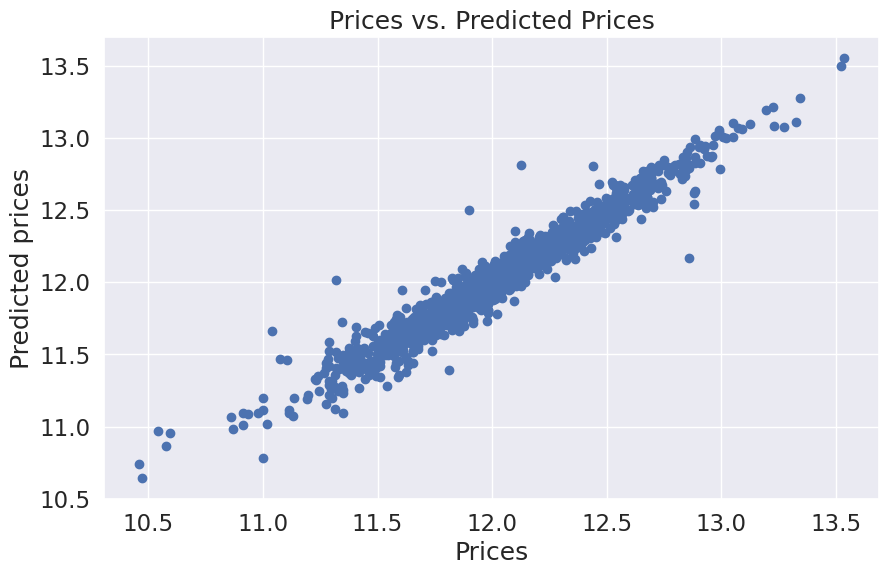

In [ ]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))
plt.scatter(y_train, y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")

Text(0, 0.5, 'Residuals')

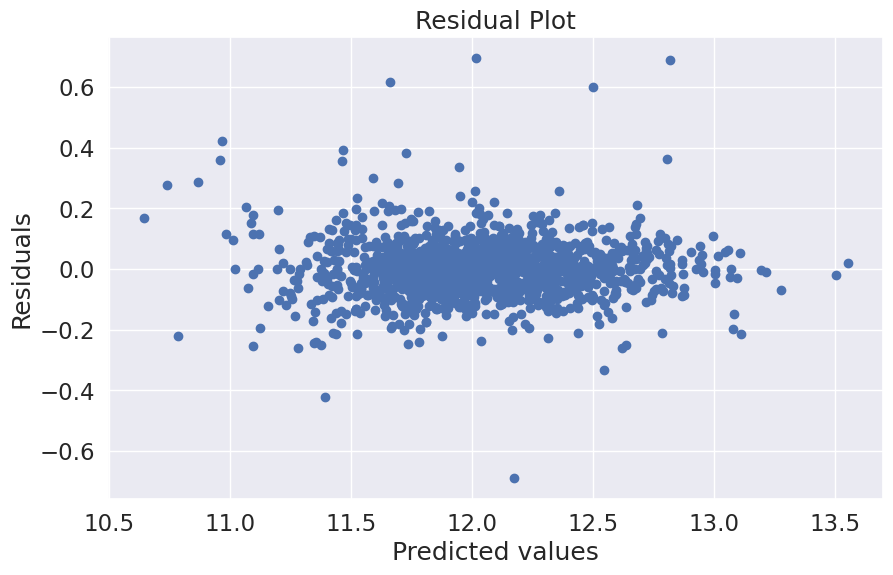

In [ ]:
# Residual plot - result should be randomly located around the 0 value
plt.figure(figsize=(10,6))
plt.scatter(y_train_pred, y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")

**LASSO model**

In [ ]:
lasso_model = make_pipeline(RobustScaler(),
                         LassoCV(alphas = [0.0004, 0.0005, 0.0006],
                                 random_state = 0,
                                 cv = 10))

lasso_model.fit(X_train, y_train)

y_train_pred = lasso_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

# print("Best alpha : {}", lasso_model.alpha_)
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LASSO: {:.3f}".format(rmse(lasso_model)))

Mean Squared Error = 0.01195394


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RMSE score for LASSO: 0.134


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


<function matplotlib.pyplot.show(close=None, block=None)>

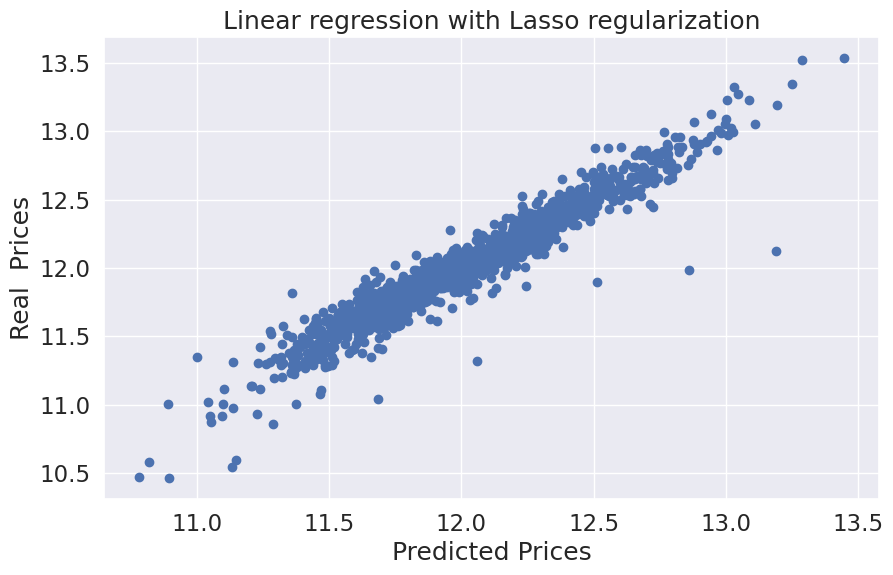

In [ ]:
# Plotting predictions
plt.figure(figsize=(10,6))
plt.scatter(y_train_pred, y_train)
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted Prices")
plt.ylabel("Real  Prices")
plt.show

**GradientBoostingRegressor**

In [ ]:
gbr = GradientBoostingRegressor(random_state=0)
param_grid = {'n_estimators': [2500],
              'max_features': [13],
              'max_depth': [5],
              'learning_rate': [0.05],
              'subsample': [0.8],
             'random_state' : [5]}

gb_model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=5)
gb_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'max_features': [13], 'n_estimators': [2500],
                         'random_state': [5], 'subsample': [0.8]})

In [ ]:
y_train_pred = gb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)
print('Best Parameters: {}'.format(gb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for GB: {:.3f}".format(rmse(gb_model)))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 13, 'n_estimators': 2500, 'random_state': 5, 'subsample': 0.8}
Mean Squared Error = 0.00001158


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RMSE score for GB: 0.123


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


**XGB Regressor**

In [ ]:
xgbreg = xgb.XGBRegressor(seed=0)
param_grid2 = {'n_estimators': [2000],
              'learning_rate': [0.05],
              'max_depth': [3, 7],
              'subsample': [0.8],
              'colsample_bytree': [0.45, 0.75]}

xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print('\n\nBest Parameters: {}'.format(xgb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for XGB: {:.3f}".format(rmse(xgb_model)))



Best Parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.8}
Mean Squared Error = 0.00051852


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

**LightGBM**

In [ ]:
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=800,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgb_model.fit(X_train, y_train)

y_train_pred = lgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LGBMRegressor: {:.4f}".format(rmse(lgb_model)))

Mean Squared Error = 0.00538207


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s


RMSE score for LGBMRegressor: 0.1234


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
